# Capstone 2: Narrative Analytics and Experimentation

## Full spectrum light bulbs treatment for Seasonal Adjustment Disorder (SAD) in countries at or above the 49th parallel. 

#### Introduction

In Kaggle's, "Global Suicide Statistics - 1985 to 2016" data set, there appears to be a higher incidence of suicide per 100k of population in countries that have long winters with less daylight. Particularly in countries at or above the 49th parallel in the Northern Hemisphere.  

The Seasonal Adjustment Disorder (SAD) is a known phenomenon in locations with fewer daylight hours during long winters. When not exposed to enough sunlight, humans tend to have a relatively higher incidence of depression and mental illness. 

Full spectrum light bulbs are a substitute for sunlight. The spectrums are similar, and are believed to reduce SAD and mental illness caused by seasonal factors like SAD. 

Secondarily the body, physical illness, may benefit from full spectrum light bulbs when exposure to the sun is limited for extended periods of time.   

For this study, suicide rates are used as a proxy for SAD, depression and poor mental health due to environmental factors.  

#### About the CDIAC dataset

Data from Kaggle: [Global Suicide Statistics - 1985 to 2016 data set](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016)

#### Problem Statements
Problem Statement For EDA:  
* Is there a significant difference in suicide rates between regions with fewer hours of daylight in winter vs greater number of hours of daylight in winter?
* Is there a difference between male and female suicide rates?  
* Is there a difference in suicide rates across age groups?  

Problem Statement For A/B Experiment:  
* Test whether the use of full spectrum light bulbs is an effective treatment for Seasonal Adjustment Disorder (SAD) observed in countries in and above the 49th parallel, in the Northern Hemisphere. 

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy.stats import ttest_ind
%matplotlib inline

## Part 1. Exploratory Data Analysis of Gloal Suicide Statistics 1985 - 2016. 

> Use quartile analysis of the suicide rate for:
> 1. Countries
> 2. Men and women
> 3. Age groups
> 4. Trend over time

### 1.1 Explore data for content and stucture

In [2]:
# LOAD DATA
df = pd.read_csv('C:/Users/DJ/Documents/AnacondaPython/SuicideStats/suicide-rates-overview-1985-to-2016/master.csv')

In [3]:
# (ROWS, COLUMNS)
df.shape

(27820, 12)

In [4]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [5]:
# RENAME COLUMNS
df.columns = ['country', 'year', 'sex', 'age', 'suicides', 'pop',
       'suicides_per_100k', 'country_year', 'hdi_for_year',
       'gdp_for_year', 'gdp_per_cap', 'generation']

In [6]:
# LOOK AT DATA AND CHANGED COLUMN NAMES
df.head(3)

,country,year,sex,age,suicides,pop,suicides_per_100k,country_year,hdi_for_year,gdp_for_year,gdp_per_cap,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X


In [7]:
# CHECK COUNTS, DATA TYPES, NON NULL VALUES
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
country              27820 non-null object
year                 27820 non-null int64
sex                  27820 non-null object
age                  27820 non-null object
suicides             27820 non-null int64
pop                  27820 non-null int64
suicides_per_100k    27820 non-null float64
country_year         27820 non-null object
hdi_for_year         8364 non-null float64
gdp_for_year         27820 non-null object
gdp_per_cap          27820 non-null int64
generation           27820 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [8]:
# DROP UNNEEDED COLUMN WITH NULLS
df.drop(columns=['hdi_for_year'], axis=1, inplace=True)

In [9]:
# ADD A 0 IN FRONT OF 5 SO SORTS IN CHART FROM LOW TO HIGH
df.loc[df['age'] == '5-14 years', 'age'] = '05-14 years'

In [10]:
df['age'].unique()

array(['15-24 years', '35-54 years', '75+ years', '25-34 years',
       '55-74 years', '05-14 years'], dtype=object)

###  1.2 Suicide rate groupings

In [11]:
#CREATE A DATAFRAME GROUPED BY COUNTRY AGGREGATING FOR MEAN SUICIDE RATES FOR ALL AGES 
df_gb_cntry_all = df.groupby('country').mean().sort_values('suicides_per_100k', 
                                                           ascending=False).reset_index()

In [12]:
#PERCENTILE FOR QUARTILE ANALYSIS
p25 = np.percentile(df_gb_cntry_all['suicides_per_100k'], 25) # return 25th percentile.
p50 = np.percentile(df_gb_cntry_all['suicides_per_100k'], 50) # return 50th percentile.
p75 = np.percentile(df_gb_cntry_all['suicides_per_100k'], 75) # return 75th percentile.

In [13]:
# CREATE LISTS
highest_rate_q4 = []
mid_rate_q3 = []
mid_rate_q2 = []
lowest_rate_q1 = []

# COUNTER FOR TOTAL NUMBER VERIFICATION
cnt=0 

# POPULATE LISTS AND COLUMN
for index, row in df_gb_cntry_all.iterrows():  
    cnt += 1
    if row['suicides_per_100k'] <=  p25:
        lowest_rate_q1.append(row['country']) 
        df_gb_cntry_all.loc[index, 'quartile'] = 'Q1_Lowest_Rate_25'
    elif row['suicides_per_100k'] > p25 and row['suicides_per_100k'] <= p50:
        mid_rate_q2.append(row['country']) 
        df_gb_cntry_all.loc[index, 'quartile'] = 'Q2_Mid_Rate_25_50'
    elif row['suicides_per_100k'] > p50 and row['suicides_per_100k'] <= p75:
        mid_rate_q3.append(row['country']) 
        df_gb_cntry_all.loc[index, 'quartile'] = 'Q3_Mid_Rate_50_75'
    else:
        highest_rate_q4.append(row['country']) 
        df_gb_cntry_all.loc[index, 'quartile'] = 'Q4_Highest_Rate_75'

#print("count =",cnt)

In [14]:
df_gb_cntry_all.head()

,country,year,suicides,pop,suicides_per_100k,gdp_per_cap,quartile
0,Lithuania,2005.419847,107.019084,2.598672e+05,40.415573,9280.549618,Q4_Highest_Rate_75
1,Sri Lanka,1997.545455,421.522727,1.382770e+06,35.295152,904.272727,Q4_Highest_Rate_75
2,Russian Federation,2002.000000,3733.771605,1.139137e+07,34.892377,6518.814815,Q4_Highest_Rate_75
3,Hungary,2003.419355,238.358065,8.020782e+05,32.761516,9370.051613,Q4_Highest_Rate_75
4,Belarus,2001.095238,237.666667,7.832234e+05,31.075913,3333.904762,Q4_Highest_Rate_75


In [15]:
print(highest_rate_q4)

['Lithuania', 'Sri Lanka', 'Russian Federation', 'Hungary', 'Belarus', 'Kazakhstan', 'Latvia', 'Slovenia', 'Estonia', 'Ukraine', 'Republic of Korea', 'Austria', 'Croatia', 'Finland', 'Guyana', 'Serbia', 'France', 'Japan', 'Suriname', 'Belgium', 'Cuba', 'Bulgaria', 'Uruguay', 'Switzerland', 'Czech Republic']


In [16]:
print(mid_rate_q3)

['Mongolia', 'Singapore', 'Luxembourg', 'Germany', 'Poland', 'Sweden', 'New Zealand', 'Macau', 'Kyrgyzstan', 'Denmark', 'Trinidad and Tobago', 'United States', 'Australia', 'Norway', 'Iceland', 'Slovakia', 'Romania', 'Canada', 'Mauritius', 'Portugal', 'Cabo Verde', 'Ireland', 'Netherlands', 'Chile', 'El Salvador']


In [17]:
print(mid_rate_q2)

['Argentina', 'Puerto Rico', 'Montenegro', 'Aruba', 'Spain', 'Israel', 'Turkmenistan', 'Italy', 'Uzbekistan', 'United Kingdom', 'Seychelles', 'Saint Lucia', 'Costa Rica', 'Thailand', 'Kiribati', 'Nicaragua', 'Ecuador', 'Belize', 'Brazil', 'Panama', 'Saint Vincent and Grenadines', 'Colombia', 'Fiji', 'Malta', 'Mexico']


In [18]:
print(lowest_rate_q1)

['Bosnia and Herzegovina', 'Georgia', 'Paraguay', 'Greece', 'San Marino', 'Albania', 'Cyprus', 'Armenia', 'Guatemala', 'Barbados', 'Philippines', 'Turkey', 'Grenada', 'Azerbaijan', 'Bahrain', 'Qatar', 'Maldives', 'United Arab Emirates', 'Bahamas', 'Kuwait', 'South Africa', 'Oman', 'Antigua and Barbuda', 'Jamaica', 'Saint Kitts and Nevis', 'Dominica']


####  Analysis:
* There are 101 countries in this data set.   
* Quartile analysis will group countries with approximatly 25 countries in each quartile.  
* For this proposal and ease of comparison, will use the highest rates in one quartile, the lowest rates in another quartile, and then group the middle two quartiles into one group of 51 countries.  
* The countries with the lowest rates appear to be in locations with shorter winters having longer periods of sunlight hours.
* The highest rate countries tend to be above the 49th parallel in the Northern Hemisphere where winters are longer and sun light hours are fewer. 
>  Europe -> Northern France and above  
>  Asia > Mongolia and Russia  
>  North America -> North of USA

### 1.3 Range, mean, and outliers

#### Visualize quartile range and check for outliers. Highest rates quartile on left.

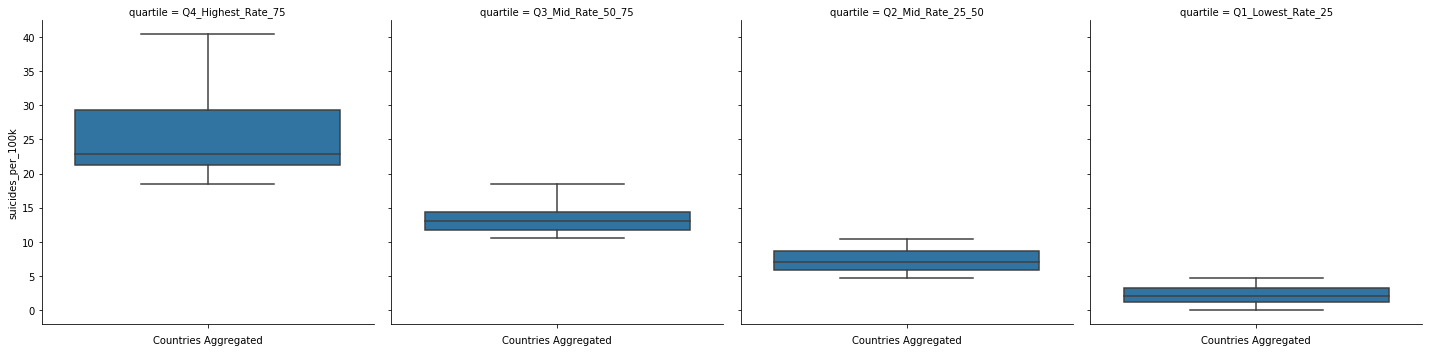

In [76]:
# CREATE COLUMNS TO BE POPULATED FOR CHARTING PURPOSES
df_gb_cntry_all['Countries Aggregated'] = ''

ax  = sns.catplot(x='Countries Aggregated',
                  y='suicides_per_100k',
                  col='quartile',
                  col_wrap=4,
                  data=df_gb_cntry_all,
                  kind='box',
                  legend=False) 

Text(0, 0.5, 'Mean Suicides Rate')

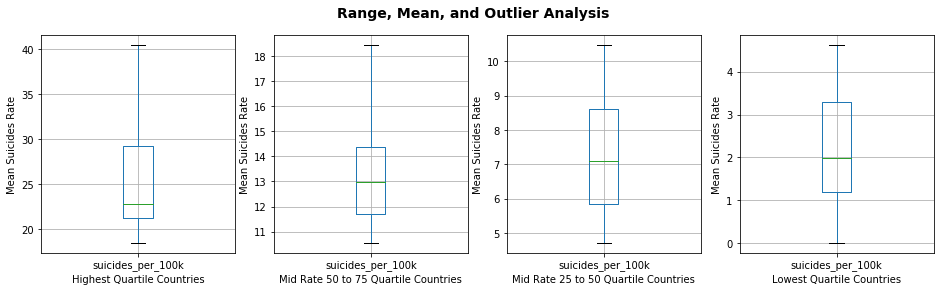

In [20]:
# MEAN IS CENTER LINE. IN THE INTERQUARTILE RANGE. 
# WHISKER +-1.5 Q3 − Q1 (INTERQUARTILE RANGE). 
# OUTLIERS ARE OUTSIDE. 

fig = plt.figure(figsize=(16, 4))
fig.suptitle('Range, Mean, and Outlier Analysis', fontsize=14, fontweight='bold')

ax1 = fig.add_subplot(141)
df_gb_cntry_all[df_gb_cntry_all['quartile'] == 
                'Q4_Highest_Rate_75'].boxplot(column='suicides_per_100k');
ax1.set_xlabel('Highest Quartile Countries')
ax1.set_ylabel('Mean Suicides Rate')

ax1 = fig.add_subplot(142)
df_gb_cntry_all[df_gb_cntry_all['quartile'] == 
                'Q3_Mid_Rate_50_75'].boxplot(column='suicides_per_100k');
ax1.set_xlabel('Mid Rate 50 to 75 Quartile Countries')
ax1.set_ylabel('Mean Suicides Rate')

ax1 = fig.add_subplot(143)
df_gb_cntry_all[df_gb_cntry_all['quartile'] == 
                'Q2_Mid_Rate_25_50'].boxplot(column='suicides_per_100k');
ax1.set_xlabel('Mid Rate 25 to 50 Quartile Countries')
ax1.set_ylabel('Mean Suicides Rate')

ax1 = fig.add_subplot(144)
df_gb_cntry_all[df_gb_cntry_all['quartile'] == 
                'Q1_Lowest_Rate_25'].boxplot(column='suicides_per_100k');
ax1.set_xlabel('Lowest Quartile Countries')
ax1.set_ylabel('Mean Suicides Rate')


#### T-Test: Suicide rates grouped by country location in relation to the 49th parallel.
Grouping are 1) At or above the 49th parallel and, 2) Not at or above the 49th parallel.   
Please note, this list was eyeballed and may be off by a few countries. 

In [42]:
at_above_49 = df_gb_cntry_all[df_gb_cntry_all['country'].isin([
    'Lithuania', 'Russian Federation', 'Hungary', 'Belarus', 'Latvia', 'Slovenia', 
    'Estonia', 'Ukraine', 'Croatia', 'Finland',  'Serbia', 'Belgium', 'Bulgaria', 
    'Czech Republic','Mongolia', 'Luxembourg', 'Germany', 'Poland', 
    'Sweden', 'Denmark', 'Norway', 'Iceland', 'Slovakia', 'Canada', 'Ireland', 
    'Netherlands','United Kingdom'])]['suicides_per_100k']

In [43]:
not_at_above_49 = df_gb_cntry_all[~df_gb_cntry_all['country'].isin([
    'Lithuania', 'Russian Federation', 'Hungary', 'Belarus', 'Latvia', 'Slovenia', 
    'Estonia', 'Ukraine', 'Croatia', 'Finland',  'Serbia', 'Belgium', 'Bulgaria', 
    'Czech Republic','Mongolia', 'Luxembourg', 'Germany', 'Poland', 
    'Sweden', 'Denmark', 'Norway', 'Iceland', 'Slovakia', 'Canada', 'Ireland', 
    'Netherlands','United Kingdom'])]['suicides_per_100k']

In [52]:
print("Mean at or above 49       {:.2f}".format(at_above_49.mean()))
print("Mean not at or above 49   {:.2f}".format(not_at_above_49.mean()))

Mean at or above 49       20.42
Mean not at or above 49   8.96


In [53]:
# RUN A T-TEST
print(ttest_ind(at_above_49, not_at_above_49))

Ttest_indResult(statistic=6.484183315007496, pvalue=3.5240111951955424e-09)


#### T-Test analysis

Level of significance: .025

H0: at_above_49 = not_at_above_49  
H1: at_above_49 > not_at_above_49  

If pvalue is < .025 for this one tailed test, then reject null hypothesis.

The probability that these two sample populations are the same is very low, thus reject null hypothesis stating the populations are the same. Countries at or above the 49th parallel have a  statistically significant higher number of suicides than those that are not. 

#### Analysis: 
* Data appears to be clean. 
* Quartile groupings of countries by suicide rate show statistically significant differences in sample populations.
* The top quartile counties have mean suicide rates of more than ten times the bottom quartile countries.  
* T-test comparing sample population of countries at or above the 49th parallel, and not at or above the 49th parallel rejected null hypothesis, meaning there is a statistically significant difference between the populations.

### 1.4 Male versus female suicide rate 

#### Visualize male and female suicide rates across quartiles to understand the demographic and identify anomolies. 

In [54]:
# CREATE DF GROUPING FOR COUNTRY AND SEX
df_gb_cntry_sex_all = df.groupby(['country','sex']).mean().reset_index()
df_gb_cntry_sex_top25 = df_gb_cntry_sex_all[df_gb_cntry_sex_all['country'].isin(['Lithuania','Sri Lanka',
            'Russian Federation','Hungary','Belarus','Kazakhstan','Latvia','Slovenia','Estonia','Ukraine',
            'Republic of Korea','Austria','Croatia','Finland','Guyana','Serbia','France','Japan','Suriname',
            'Belgium','Cuba','Bulgaria','Uruguay','Switzerland','Czech Republic'])].reset_index()
df_gb_cntry_sex_bot25 = df_gb_cntry_sex_all[df_gb_cntry_sex_all['country'].isin(['South Africa','Kuwait',
            'Bahamas','United Arab Emirates','Maldives','Qatar','Bahrain','Azerbaijan','Grenada','Turkey',
            'Philippines','Barbados','Guatemala','Armenia','Cyprus','Albania','San Marino','Greece','Paraguay',
            'Georgia','Bosnia and Herzegovina','Mexico','Malta','Fiji','Colombia'])].reset_index()
df_gb_cntry_sex_mid_25_to_75 = df_gb_cntry_sex_all[~df_gb_cntry_sex_all['country'].isin(['Lithuania','Sri Lanka',
            'Russian Federation','Hungary','Belarus','Kazakhstan','Latvia','Slovenia','Estonia','Ukraine',
            'Republic of Korea','Austria','Croatia','Finland','Guyana','Serbia','France','Japan','Suriname',
            'Belgium','Cuba','Bulgaria','Uruguay','Switzerland','Czech Republic','South Africa','Kuwait',
            'Bahamas','United Arab Emirates','Maldives','Qatar','Bahrain','Azerbaijan','Grenada','Turkey',
            'Philippines','Barbados','Guatemala','Armenia','Cyprus','Albania','San Marino','Greece','Paraguay',
            'Georgia','Bosnia and Herzegovina','Mexico','Malta','Fiji','Colombia'])].reset_index()

In [55]:
df_gb_cntry_sex_top25 = df_gb_cntry_sex_all[df_gb_cntry_sex_all['country'].isin(['Lithuania','Sri Lanka',
            'Russian Federation','Hungary','Belarus','Kazakhstan','Latvia','Slovenia','Estonia','Ukraine',
            'Republic of Korea','Austria','Croatia','Finland','Guyana','Serbia','France','Japan','Suriname',
            'Belgium','Cuba','Bulgaria','Uruguay','Switzerland','Czech Republic'])].reset_index()


In [56]:
df_gb_cntry_age_sex = pd.DataFrame()

for index, row in df.iterrows():
    if row['country'] in highest_rate_q4:
        df_gb_cntry_age_sex.loc[index, 'quartile'] = 'Q4_Highest_Rate_75'
    elif row['country'] in mid_rate_q3:
        df_gb_cntry_age_sex.loc[index, 'quartile'] = 'Q3_Mid_Rate_50_75'
    elif row['country'] in mid_rate_q2:
        df_gb_cntry_age_sex.loc[index, 'quartile'] = 'Q2_Mid_Rate_25_50'
    elif row['country'] in lowest_rate_q1:
        df_gb_cntry_age_sex.loc[index, 'quartile'] = 'Q1_Lowest_Rate_25'

In [57]:
# PUT IN A DEFAULT VALUE SO CAN CHART A CONTINUOUS VARIABLE AGAINST A CATEGORICAL VARIABLE
df_gb_cntry_sex_all['All'] = 'Countries'
df_gb_cntry_sex_top25['Top25'] = 'Countries'
df_gb_cntry_sex_bot25['Bottom25'] = 'Countries'
df_gb_cntry_sex_mid_25_to_75['25_to_75']= 'Countries'

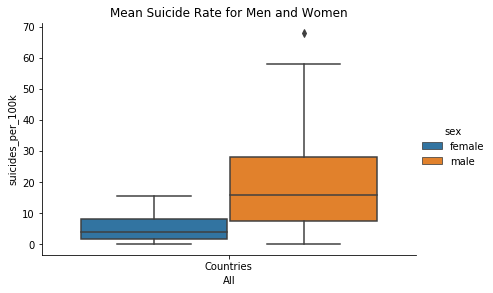

In [58]:
# PLOT MEAN MALE AND FEMALE SUICIDE RATE FOR ALL COUNTRIES
sns.catplot(x='All', y='suicides_per_100k', hue='sex', kind="box", data=df_gb_cntry_sex_all, 
            height=4, aspect=1.5)
plt.title('Mean Suicide Rate for Men and Women')
plt.show()

In [61]:
# MEAN RATE FOR ALL COUNTRIES AGGREGATED ON MALE AND FEMALE 
round(df_gb_cntry_sex_all.groupby('sex')['suicides_per_100k'].mean(),0)

sex
female     5.0
male      19.0
Name: suicides_per_100k, dtype: float64

In [62]:
# HIGHEST RATE COUNTRIES AGGREGATED ON MALE AND FEMALE 
round(df_gb_cntry_sex_top25.groupby('sex')['suicides_per_100k'].mean(),0)

sex
female    11.0
male      40.0
Name: suicides_per_100k, dtype: float64

In [63]:
# COUNTRIES NOT IN TOP OR BOTTOM AGGREGATED ON MALE AND FEMALE 
round(df_gb_cntry_sex_mid_25_to_75.groupby('sex')['suicides_per_100k'].mean(),0)

sex
female     4.0
male      15.0
Name: suicides_per_100k, dtype: float64

In [64]:
# LOWEST RATE COUNTRIES AGGREGATED ON MALE AND FEMALE 
round(df_gb_cntry_sex_bot25.groupby('sex')['suicides_per_100k'].mean(),0)

sex
female    1.0
male      5.0
Name: suicides_per_100k, dtype: float64

#### T-Test: Gender group

Groupings are 1) male and, 2) female

In [66]:
male = df_gb_cntry_sex_all[df_gb_cntry_sex_all['sex'] == 'male']['suicides_per_100k']
female = df_gb_cntry_sex_all[df_gb_cntry_sex_all['sex'] == 'female']['suicides_per_100k']

In [80]:
print("Male mean   = {:.2f}".format(male.mean()))
print("Female mean = {:.2f}".format(female.mean()))

Male mean   = 19.01
Female mean = 5.04


In [67]:
# RUN A T-TEST
print(ttest_ind(male, female))

Ttest_indResult(statistic=9.038281214351052, pvalue=1.3814753861789921e-16)


#### T-Test analysis: Suicide rates grouped by gender

Level of significance: .025

H0: male = female  
H1: male > female  

If pvalue is < .025 for this one tailed test, then reject null hypothesis.

The probability that these two sample populations are the same is very low, thus reject null hypothesis stating the populations are the same. Males have a statistically significant higher number of suicides than females. 

#### Analysis:
* Significantly higher suicide rate for men vs women. Males suicide rates are close to four times that of females.
* Suicide rate ratio between genders appear to be consistent across quartile groupings. 
* Question, are males more susceptible to mental illness than females or more willing to commit suicide?   
* As suicide is extreme, the question of whether mental illness is similar across the sex category is a relevant question particularly in regions with high suicide rates that may have an environmental or seasonal causal variable, sunlight. 

### 1.5 Suicide rate by age group

#### Visualize the suicide rate across age groups and gender to see if consistent across groups and if any anomolies are present.

In [68]:
# CREATE ARRAYS GROUPING BY COUNTRY AND AGE
df_gb_cntry_age_all = df.groupby(['country','age','sex']).mean().reset_index()
df_gb_cntry_age_top25  = df_gb_cntry_age_all[df_gb_cntry_age_all['country'].isin(['Lithuania','Sri Lanka',
            'Russian Federation','Hungary','Belarus','Kazakhstan','Latvia','Slovenia','Estonia','Ukraine',
            'Republic of Korea','Austria','Croatia','Finland','Guyana','Serbia','France','Japan','Suriname',
            'Belgium','Cuba','Bulgaria','Uruguay','Switzerland','Czech Republic'])].reset_index() 
df_gb_cntry_age_bot25  = df_gb_cntry_age_all[df_gb_cntry_age_all['country'].isin(['South Africa','Kuwait',
            'Bahamas','United Arab Emirates','Maldives','Qatar','Bahrain','Azerbaijan','Grenada','Turkey',
            'Philippines','Barbados','Guatemala','Armenia','Cyprus','Albania','San Marino','Greece','Paraguay',
            'Georgia','Bosnia and Herzegovina','Mexico','Malta','Fiji','Colombia'])].reset_index() 
df_gb_cntry_age_mid_25_to_75 = df_gb_cntry_age_all[~df_gb_cntry_age_all['country'].isin(['Lithuania','Sri Lanka',
            'Russian Federation','Hungary','Belarus','Kazakhstan','Latvia','Slovenia','Estonia','Ukraine',
            'Republic of Korea','Austria','Croatia','Finland','Guyana','Serbia','France','Japan','Suriname',
            'Belgium','Cuba','Bulgaria','Uruguay','Switzerland','Czech Republic','South Africa','Kuwait',
            'Bahamas','United Arab Emirates','Maldives','Qatar','Bahrain','Azerbaijan','Grenada','Turkey',
            'Philippines','Barbados','Guatemala','Armenia','Cyprus','Albania','San Marino','Greece','Paraguay',
            'Georgia','Bosnia and Herzegovina','Mexico','Malta','Fiji','Colombia'])].reset_index()

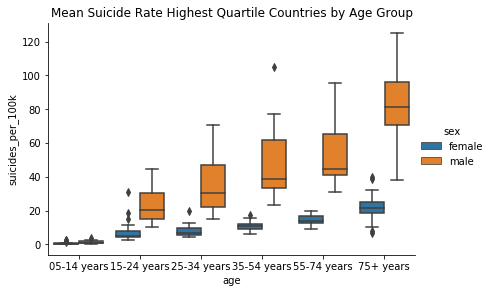

In [69]:
sns.catplot(x='age', y='suicides_per_100k', kind="box", hue='sex',
            data=df_gb_cntry_age_top25, height=4, aspect=1.5)
plt.title('Mean Suicide Rate Highest Quartile Countries by Age Group')
plt.show()

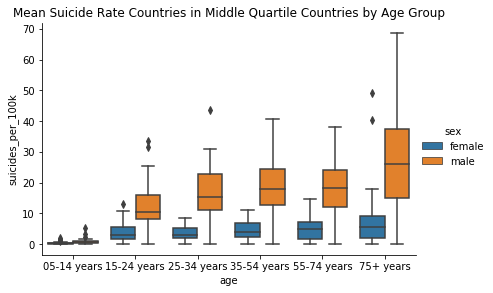

In [70]:
sns.catplot(x='age', y='suicides_per_100k', kind="box", hue='sex',
            data=df_gb_cntry_age_mid_25_to_75, height=4, aspect=1.5)
plt.title('Mean Suicide Rate Countries in Middle Quartile Countries by Age Group')
plt.show()

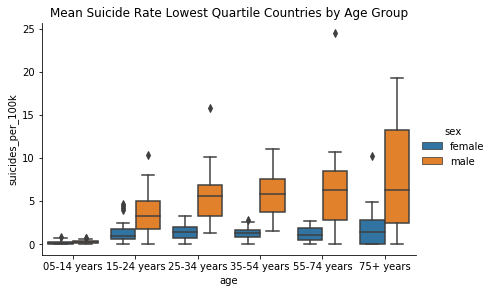

In [71]:
sns.catplot(x='age', y='suicides_per_100k', kind="box", hue='sex', 
            data=df_gb_cntry_age_bot25, height=4, aspect=1.5)
plt.title('Mean Suicide Rate Lowest Quartile Countries by Age Group')
plt.show()
#plt.close(2)

#### T-Test: Age group

In [73]:
a5_14  = df_gb_cntry_age_all[df_gb_cntry_age_all['age'] == '05-14 years']['suicides_per_100k']
a15_24 = df_gb_cntry_age_all[df_gb_cntry_age_all['age'] == '15-24 years']['suicides_per_100k']
a25_34 = df_gb_cntry_age_all[df_gb_cntry_age_all['age'] == '25-34 years']['suicides_per_100k']
a35_54 = df_gb_cntry_age_all[df_gb_cntry_age_all['age'] == '35-54 years']['suicides_per_100k']
a55_74 = df_gb_cntry_age_all[df_gb_cntry_age_all['age'] == '55-74 years']['suicides_per_100k']
a75    = df_gb_cntry_age_all[df_gb_cntry_age_all['age'] == '75+ years'  ]['suicides_per_100k']

In [84]:
print("a5_14  mean = {:.2f}".format(a5_14.mean()))
print("a15_24 mean = {:.2f}".format(a15_24.mean()))
print("a25_34 mean = {:.2f}".format(a25_34.mean()))
print("a35_54 mean = {:.2f}".format(a35_54.mean()))
print("a55_74 mean = {:.2f}".format(a55_74.mean()))
print("a75    mean = {:.2f}".format(a75.mean()))

a5_14  mean = 0.61
a15_24 mean = 8.41
a25_34 mean = 11.43
a35_54 mean = 14.01
a55_74 mean = 15.04
a75    mean = 22.40


In [75]:
# RUN A T-TEST
print(ttest_ind(a5_14, a15_24))
print(ttest_ind(a15_24, a25_34))
print(ttest_ind(a25_34, a35_54))
print(ttest_ind(a35_54, a55_74))
print(ttest_ind(a55_74, a75))

Ttest_indResult(statistic=-12.221673001213215, pvalue=2.0879299664685995e-29)
Ttest_indResult(statistic=-2.678382684331624, pvalue=0.0077012943636017885)
Ttest_indResult(statistic=-1.7165651392905037, pvalue=0.08682897481334029)
Ttest_indResult(statistic=-0.6080846137568019, pvalue=0.5434747440491868)
Ttest_indResult(statistic=-3.3000761736885336, pvalue=0.0010528317384376974)


#### T-Test analysis: Suicide rates grouped by age

Level of significance: .025

#### Multiple groups, so generally testing if suicides rates go up with age
H0: age younger = age older  
H1: age younger < age older  

If pvalue is < .025 for this one tailed test, then reject null hypothesis.

Overall, significant diff between:
a5_14 and a15_24
a15_24 and a25_34

Not a significant difference between:
a25_34 and a35_54
and a35_54 and a55_74

Significant difference between:
a55_74 and a75

Suicide averages increase with age. Significant difference between lowest three age groups and highest two age groups. Middle shows a slight increase up, but not statistically significant, particularly not significant between a35_54 and a55_74.

#### Analysis
* Trends in the data appear to be consistent across gender and age. 
* 75+ has the highest suicide rate of any age group.   
* Generally speaking it appears that the mean suicide rate increases with age.
* As for the lowest rate countries, the suicide rate is relatively flat from age groups 25 - 74, then slightly inceases for > 75 years of age.
* When comparing the highest, middle, and lowest rate quartiles, both men and women are significantly higher in the highest quartile and lower in the middle and lowest rate quartile. 

### 1.6 Trend over time

#### Analyze the suicide rate over time

In [ ]:
df_gb_year_all = df.groupby(['year']).mean().reset_index()

In [ ]:
#sns.catplot(x='year', y='suicides_per_100k', kind="line", data=df_gb_year_all, height=4, aspect=1.5)
sns.relplot(x='year', y='suicides_per_100k', data=df_gb_year_all, kind="line");
plt.title('Mean Suicide Rate for All Countries by Year')
plt.show()

#### Analysis
* Over time it appears suicide rates went up until about 1995 and then started going down to about 2015. 
* Suicides rates appear to trend. 
* This aggregation may be illustrating there are likly other causal factor(s) in addition to the environmental exposure to daylight. 

### 1.7 Potential issues, skews, or other factors impacting the data set.

* Cultural: May not report to authorities.  
* Intentional exclusion: Rural or remote populations may be excluded. May treat young, old, male, or female differently with regard to mental health and suicide.   
* Political: Government may underreport intentionally. May vary on who is in power.  
* Regional Events: Break up of USSR, war, extreme weather, disasters, or lack of these conditions.  
* Economic: Conditions and opportunity impacting prosperity or standard of living changes.    
* Demographic: Quantity of elderly population over time.  

## Part 2. A/B Experiment Design: Study Proposal 

### 2.1 Problem Statement

Test whether the use of full spectrum light bulbs is an effective treatment for Seasonal Adjustment Disorder (SAD) observed in the above the 49th parallel in the Northern Hemisphere. 

### 2.2 Potential solution

Full spectrum light bulbs used in the workplace as a substitue for natural sunlight, and an extension of daylight hours to eight hours. The full spectrum bulb and the sun have similar spectrums. The full spectrum exposure is believed to reduce SAD, implying that full spectrum light bulbs can improve mental illness caused by seasonal environmental factors. 

### 2.3 Study - Overview

A large MNC with a light bulb division sees a pattern of SAD, depression, mental illness, and suicide in locations with  long winters. The company then develops a low cost full spectrum light bulb which they want to to test if suicides are reduced as a result. 

The ideal would be to have a study that establishes the test group with a measurably significant difference to the control group as a result of the treatment.  

The company would then market the bulbs as improving mental health and SAD condition in countries with long winters and fewer hours of daylight. 

The majority of high suicide rate countries are primarily in the northern part of the northern hemisphere near to or north of the 49th parallel.    

### 2.4 Study - Method of testing the treatment

Partner with Governments and large corporations who own office buildings in target cities/countries with long winters. 
    The treatment for the test group will be to outfit office buildings with full spectrum bulbs. This A/B test will have a control group where full spectrum bulbs are not installed, and a test group which have full spectrum bulb installed. 
    
Prior to the test, employess will fill out an anonomous online form designed by professionals to test the current state of the subject's mental health, which will take approximately twenty minutes. The forms will also be given to the employees half way through the winter, and again at the end of winter. 

The test will take into account sex and age groups. Age groups will be binned like the following: 15-24 years, 25-34 years, 35-54 years, 55-74 years.

Attribute data to collect:
city, country, year, sex, age, test_grp, result1, result2, result3, start_date, end_date, hrs_week  	

Goal is for each building to have over 500 employees. The buildings will be located in multiple countries, in the city center.

### 2.5 Rollout Plan 
The test will seek to have a sample of over 10,000 people in test, and a control group of over 10,000 people. The goal is to have 20 test buildings and 20 control buildings.  

In order to test installation and infrastruction do a controlled rollout, ten percent in first two weeks, then 45% the next two weeks, and the final 45% in the two weeks after that. Goal is to have installed prior to start of winter.  

The reason to gradually rollout the treatment is to validate and learn the process of installation, voltage considerations, and other conditions such as policies, politics, and unions. Also go over the filling out of forms and conversion best practices.  


## Part 3. Evaluation Plan: Success Measurement

The null hypothesis (H0): 
>Difference between the control and test group standardized mental health tests scores are statistically insignificant, essentially the same.

The Alternate Hypothesis(H1): 
> Statistically significant difference between test scores showing fewer mental health issues in the population exposed to full spectrum light bulbs. 

H0: test group = control group  
H1: test group < control group

### 3.1 Success metric   

Will use a standardized depression test to analyze if the full spectrum light bulb treatment reduces depression. 

The depression test score is the test metric of interest. Each test will have a score. The scores will be averaged for sex, age, country, and city categories. 

A one-tailed t-test, with alpha value of .025, will be used to accept or reject the null hypothesis.  

If can conclude there is a significant diffence between the treatment group and the control group, thus rejecting the null hypothesis, then the study will be considered a success.  

In p-value terms, the probability will need to be less than .025 to reject the null hypothesis.

### 3.2 Secondary metrics  
As the Seasonal Adjustment Disorder (SAD) is a known phenomenon there may be governments, drug companies, universities, insurance companies, and other institutions interested in collaborating to better understand SAD and potential impacts on physical health.   

Have a health questionaire designed by professionals identifying if physical health is impacted by SAD. 

Include in study, and test the null hypothesis with a t-test, and success metrics.

## Part 4. Thoughts on Preventing Bias During Testing

#### Sampling bias  
> Have a control and test group in each city. In control and test groups have proportional representation of age, gender, and cultural groups.     

#### Contextual bias  
> Eliminate anyone with less than 80% hours in the office per week on average due to vacation or personal.   
> Are there outside events significantly impacting the employee or community?  